In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))

In [3]:
settings.domestic_leagues.append('ELC')
settings.league_info['ELC']={'nr_cl': 2, 'nr_deg': 3}

In [4]:
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()

In [5]:
year = 2019
league = 'BPL'
calib.calibrate_teams(league,year)

In [6]:
season = Season(league, year,calib, use_home_advantage=False)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)
season.process_simulation()

home advantage 1


In [7]:
#i=season.match_id['bpl_astonvilla_manchesterunited_2020-07-09']
#hg=season.simulated_home_goals[i,:]
#ag=season.simulated_away_goals[i,:]
#ind = ag>hg
ind = None
season.season_report(ind=ind)

,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Liverpool,34,92,99.9,96,104,1,1,100.0,100.00,5.83,0.27,0.00
Manchester City,34,69,79.5,76,81,2,2,0.0,100.00,7.16,0.19,0.00
Chelsea,34,60,67.0,63,72,5,3,0.0,74.46,5.33,0.31,0.00
Manchester United,34,58,66.3,62,70,5,3,0.0,67.11,5.25,0.21,0.00
Leicester City,34,59,65.6,61,69,5,3,0.0,58.16,4.33,0.28,0.00
Wolverhampton,34,52,58.2,54,62,9,6,0.0,0.24,3.12,0.22,0.00
Arsenal,34,50,56.6,52,60,10,6,0.0,0.01,4.26,0.29,0.00
Sheffield United,34,51,55.2,52,60,11,6,0.0,0.02,3.04,0.33,0.00
Tottenham Hotspur,34,49,54.3,50,59,11,6,0.0,0.00,3.63,0.35,0.00
Burnley,34,49,53.5,50,58,12,7,0.0,0.00,2.97,0.35,0.00


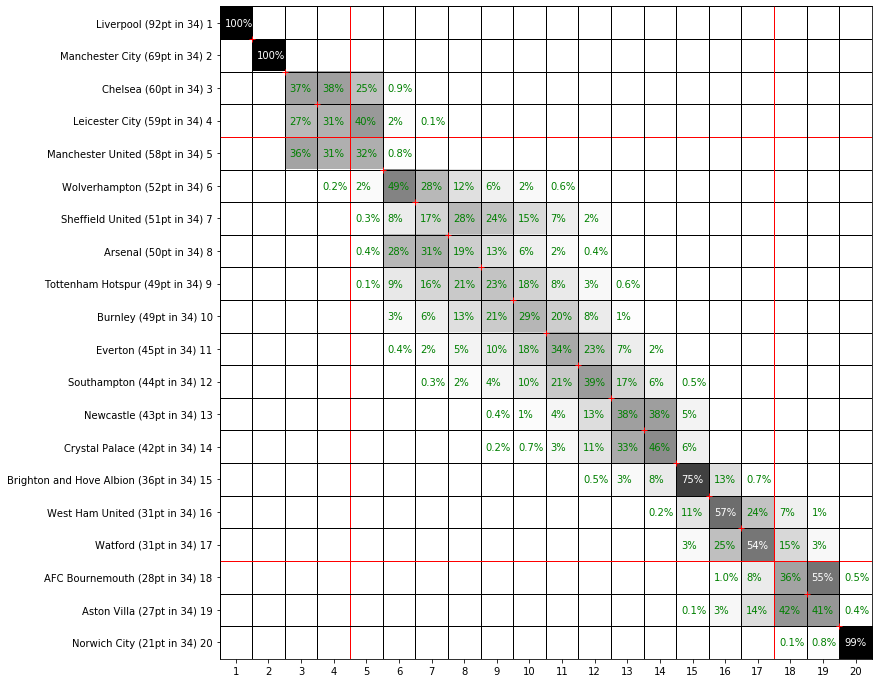

In [8]:
season.probability_grid(ind=ind);

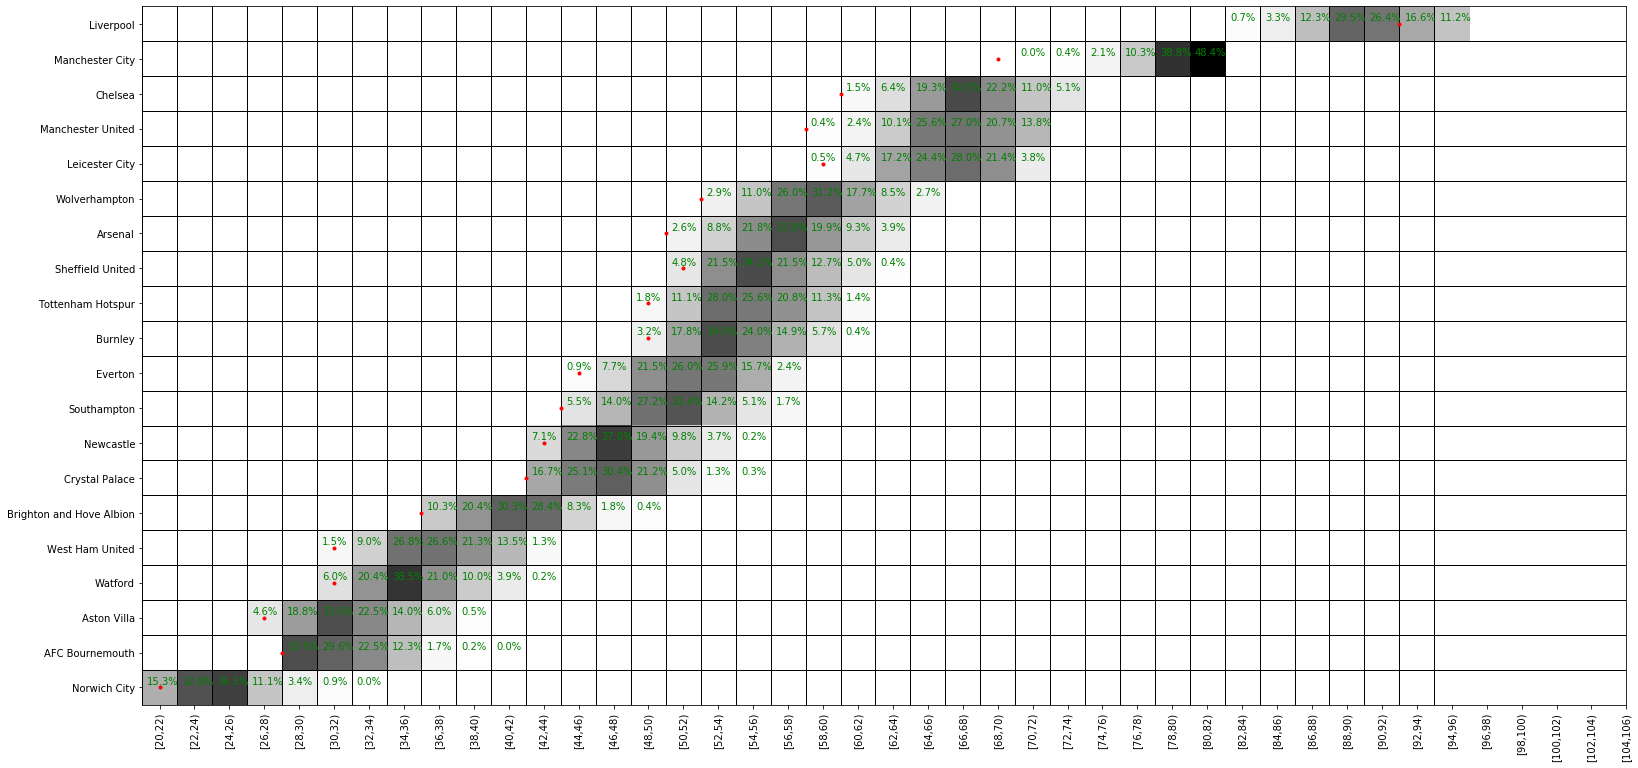

In [9]:
season.points_probability_grid(ind=ind);

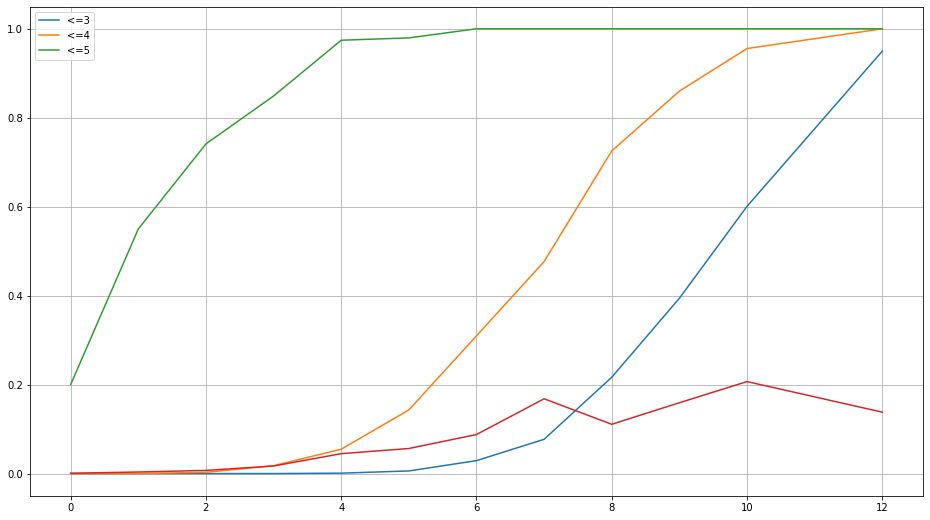

In [10]:

def plot_place_per_points(team_name,lgh):
    p0=lgh.current_points[team_name]

    i=lgh.team_id[team_name]

    #p0=league.current_points['Wolverhampton']
    #i = league.team_id['Wolverhampton']

    P=(lgh.points_per_team[i,:]-p0).astype(int)
    pp=np.unique(P)

    prob4=[]
    prob3=[]
    prob5=[]
    probp=[]
    for p in pp:
        ind =( P==p)
        probp.append(ind.sum()/ind.size)
        prob4.append(np.sum(lgh.place_per_team[i,ind]<=4)/ind.sum())
        prob3.append(np.sum(lgh.place_per_team[i,ind]<=3)/ind.sum())
        prob5.append(np.sum(lgh.place_per_team[i,ind]<=5)/ind.sum())

    C = len([x for x in lgh.matches_to_sim if team_name in [x.home_team.name,x.away_team.name]])
    C=1
    plt.figure(figsize=(16,9))
    plt.plot(pp/C,prob3,label='<=3')
    plt.plot(pp/C,prob4,label='<=4')
    plt.plot(pp/C,prob5,label='<=5')
    plt.plot(pp/C,probp)
    plt.grid(True)
    plt.legend()
plot_place_per_points(season.teams['Manchester United'].name,season)
#plot_place_per_points(league.teams['Wolverhampton'].name,league)

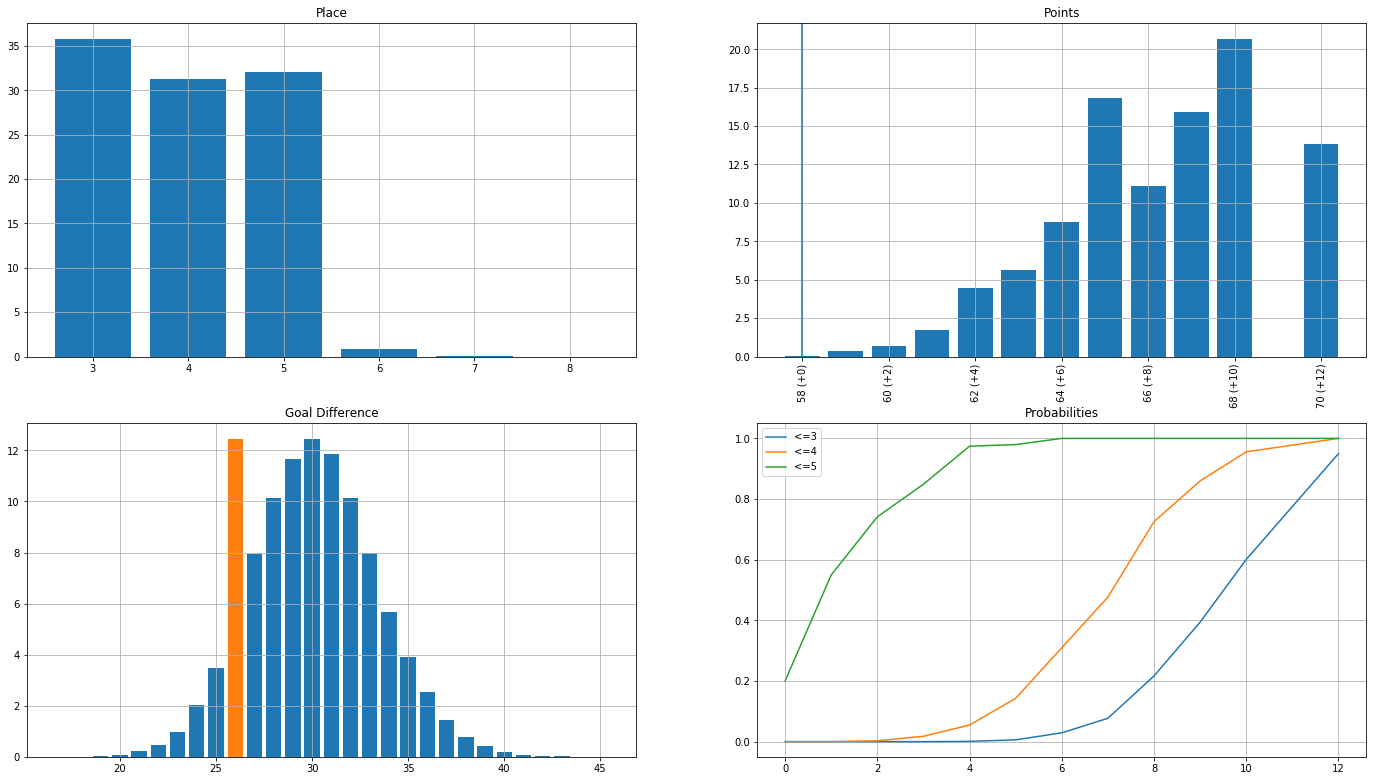

In [11]:
my_team = season.teams['Manchester United']

names = []
importance = []
for m in season.matches_to_sim:
    p=season.what_if(m,ref_team=my_team,place=4,or_better=True,show_plot=False)[0]
    names.append(m.id)
    importance.append(np.sum((p[1:]-p[0])**2))

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
season.team_report(my_team)

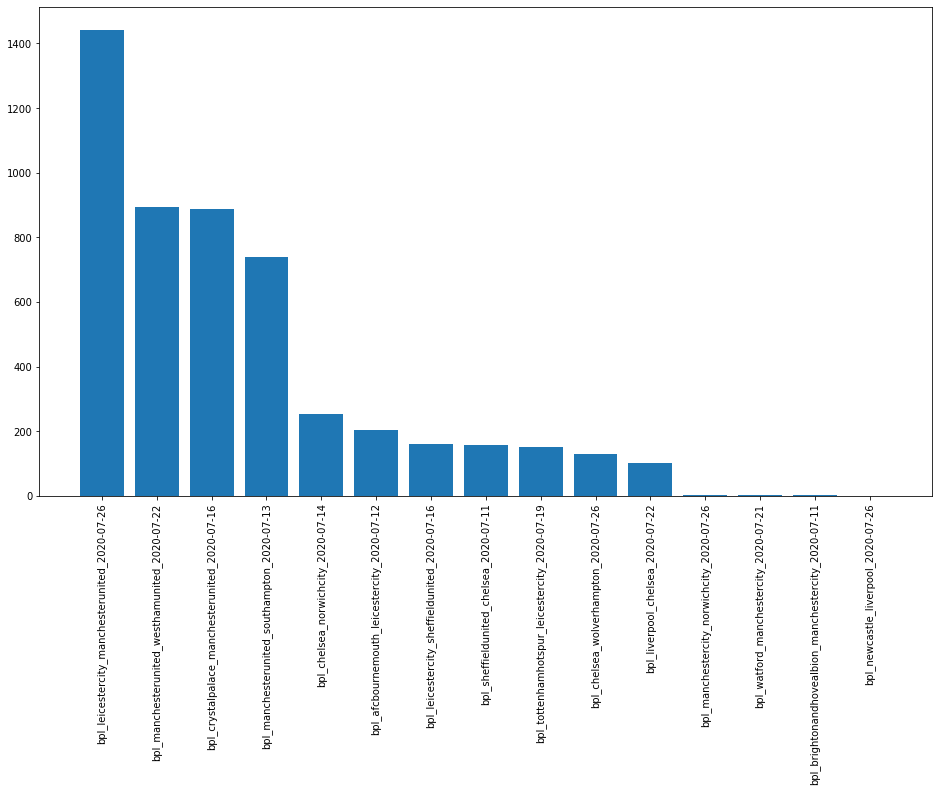

In [12]:
n_plot=15

plt.figure(figsize=(16,9))
plt.bar(np.arange(n_plot),importance[:n_plot])
plt.xticks(np.arange(n_plot),names[:n_plot],rotation=90);

(array([67.107     , 77.88756332, 45.04722414, 55.43766578]),
 <Figure size 1152x648 with 1 Axes>)

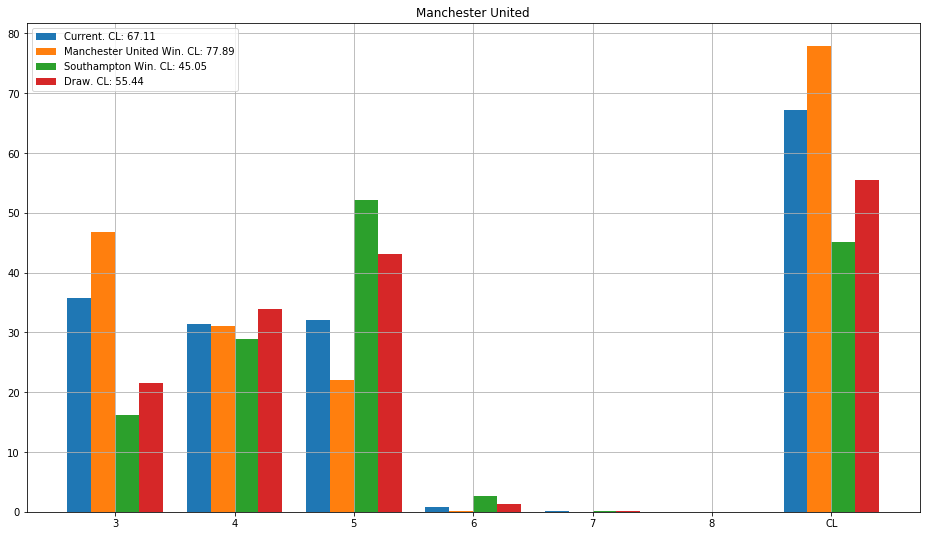

In [13]:
match = season.matches_to_sim[season.match_id['bpl_manchesterunited_southampton_2020-07-13']]
my_team=season.teams['Manchester United']
season.what_if(match,ref_team=my_team,place=4,or_better=True)

D:\Miniconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


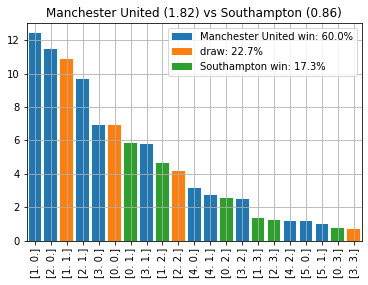

In [14]:
match.home_team.outcomes_vs(match.away_team)

In [21]:
season.matches_remaining(team_filter=['Manchester U','Leic','Chel'])

,Date,Home,Away,Home Wins,Draw,Away Wins,av HG,av AG
0,2020-07-11,Sheffield United,Chelsea,19.8,23.3,56.9,0.9,1.8
1,2020-07-12,AFC Bournemouth,Leicester City,16.9,21.4,61.7,0.9,1.9
2,2020-07-13,Manchester United,Southampton,60.0,22.6,17.4,1.8,0.9
3,2020-07-14,Chelsea,Norwich City,71.7,17.5,10.7,2.2,0.7
4,2020-07-16,Crystal Palace,Manchester United,11.2,19.5,69.3,0.7,2.0
5,2020-07-16,Leicester City,Sheffield United,50.8,27.0,22.2,1.4,0.8
6,2020-07-19,Tottenham Hotspur,Leicester City,24.9,25.9,49.2,1.0,1.5
7,2020-07-22,Liverpool,Chelsea,45.6,23.0,31.4,1.8,1.5
8,2020-07-22,Manchester United,West Ham United,67.8,19.0,13.2,2.2,0.8
9,2020-07-26,Leicester City,Manchester United,23.9,26.5,49.6,0.9,1.5


In [16]:
[f for f in season.matches_to_sim if 'Leicester City' in [f.home_team.name,f.away_team.name]]

[             metric  AFC Bournemouth  Leicester City
 0             goals              NaN             NaN
 1                xg              NaN             NaN
 2              nsxg              NaN             NaN
 3                ag              NaN             NaN
 4  forecasted goals          0.89812         1.93795
 5   win probability         16.85100        61.73700
 6  draw probability         21.41200        21.41200,
              metric  Leicester City  Sheffield United
 0             goals             NaN               NaN
 1                xg             NaN               NaN
 2              nsxg             NaN               NaN
 3                ag             NaN               NaN
 4  forecasted goals         1.42568           0.84441
 5   win probability        50.83500          22.18900
 6  draw probability        26.97600          26.97600,
              metric  Tottenham Hotspur  Leicester City
 0             goals                NaN             NaN
 1            

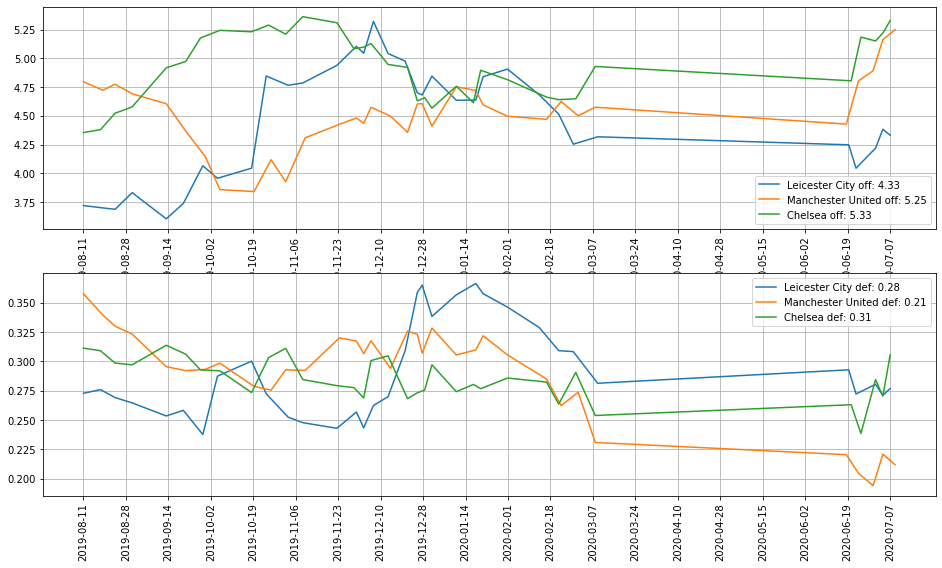

In [17]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


In [18]:
'' in 'United'

True